<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/lstm/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [13]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Sequential
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [5]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'RMSprop'   
]

In [6]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
99620,defective watches ordered two of these diver w...,0
254042,love it my son just got dog train for his firs...,1
165143,a note to all peruvians do not buy this book i...,0
140042,better get them now these filters get NUMBER s...,1
60094,does not hold stair treads optimum technologie...,0


In [7]:
test = read_data(test_path, cols)
test.sample(5)

,text,target
11331,amazing guidance this book is a wonderful guid...,1
18582,works great before you drop it this is my seco...,1
17002,sacred sellout sacred love is a big load of cr...,0
10475,cool karma the jacket of this book is what cau...,1
15455,great for traveling i am not a hardy traveler ...,1


In [8]:
train, val = split_data(data)

In [9]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [10]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

In [11]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [12]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])

In [14]:
def build_lstm(hp):
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(
        Embedding(
          num_words, hp.get('output_dim')
        )
    )
    model.add(LSTM(hp.get('lstm_units')))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=get_optimizer(hp.get('optimizer')),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [15]:
hp = HyperParameters()
hp.Int('output_dim', 16, 64, 16)
hp.Choice('lstm_units', [2, 8, 16, 32, 64])
hp.Choice('optimizer', optimizers)

'Adam'

In [17]:
tuner = get_tuner(build_lstm,'/content/drive/MyDrive/sentiment/LSTM',\
                  'LSTM_B32',hp, 2, 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 2)                 152       
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
Total params: 160,158
Trainable params: 160,158
Non-trainable params: 0
_________________________________________________________________


## Train

In [18]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=2,
    validation_data=(sequence_val, val_target),
    batch_size=32,
    use_multiprocessing=True
)

Trial 2 Complete [00h 11m 33s]
val_loss: 0.1761021390557289

Best val_loss So Far: 0.17160198092460632
Total elapsed time: 00h 24m 21s
INFO:tensorflow:Oracle triggered exit


## Refit

In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 673,154
Trainable params: 673,154
Non-trainable params: 0
_________________________________________________________________


In [22]:
best_model = get_model_from_config(
    best_model,
    get_optimizer(tuner.get_best_hyperparameters()[0].get('optimizer'))
)

In [23]:
cb = get_callbacks('lstm.h5')

In [24]:
history = best_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs=100,
    callbacks=cb
)

Epoch 1/100
9563/9563 [==============================] - 193s 20ms/step - loss: 0.2958 - accuracy: 0.8773 - precision: 0.8773 - recall: 0.8773 - true_positives: 136944.9004 - true_negatives: 136944.9004 - false_positives: 16095.0904 - false_negatives: 16095.0904 - val_loss: 0.1865 - val_accuracy: 0.9284 - val_precision: 0.9284 - val_recall: 0.9284 - val_true_positives: 50133.0000 - val_true_negatives: 50133.0000 - val_false_positives: 3865.0000 - val_false_negatives: 3865.0000

Epoch 00001: val_loss improved from inf to 0.18646, saving model to lstm.h5
Epoch 2/100
9563/9563 [==============================] - 195s 20ms/step - loss: 0.1789 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - true_positives: 142685.3883 - true_negatives: 142685.3883 - false_positives: 10354.6025 - false_negatives: 10354.6025 - val_loss: 0.1685 - val_accuracy: 0.9342 - val_precision: 0.9342 - val_recall: 0.9342 - val_true_positives: 50443.0000 - val_true_negatives: 50443.0000 - val_false_positives: 35

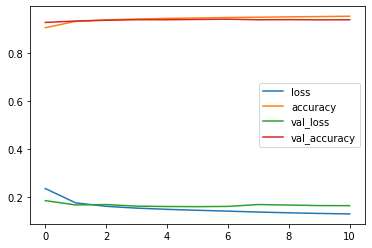

In [25]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
pd.DataFrame(history.history)[metr].plot()

In [26]:
# dump(history.history,'/content/drive/MyDrive/sentiment/LSTM/LSTM_B32/history.pickle')
# dump(tokenizer,'/content/drive/MyDrive/sentiment/LSTM/LSTM_B32/tokenizer.pickle')

# Test

In [19]:
sequence_test = get_sequences(tokenizer, max_len, test['text'])
test_target = OH_transform(test['target'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 673,154
Trainable params: 673,154
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 4s 5ms/step
Accuracy:	93.5%


              precision    recall  f1-score   support

           0       0.93      0.94      0.94     10000
           1       0.94      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



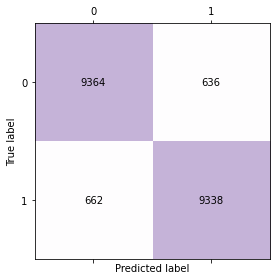

In [20]:
model_evaluate(tuner.get_best_models(num_models=1)[0], sequence_test, \
               test_target, 32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 4s 5ms/step
Accuracy:	93.9%


              precision    recall  f1-score   support

           0       0.93      0.94      0.94     10000
           1       0.94      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



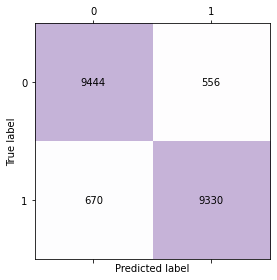

In [27]:
model_evaluate(best_model, sequence_test, \
               test_target, 32)